# Particle Filtering Gaussian State Space Model + ESS Resampling

In [1]:
from DataUtils import DataInterface
import numpy as np;
import matplotlib.pyplot as plt;
from mpl_toolkits import mplot3d;

%matplotlib inline

## Reading Sensor Data

In [2]:
data_interface = DataInterface(
    "/home/an/workspace/Classes/Spring 2022/CS-179/Project/urban16/sensor_data/gps.csv",
    "/home/an/workspace/Classes/Spring 2022/CS-179/Project/urban16/sensor_data/xsens_imu.csv",
    "/home/an/workspace/Classes/Spring 2022/CS-179/Project/urban16/sensor_data/encoder.csv"
)

In [3]:
data = data_interface.read()

In [4]:
gps = data['gps_data']
imu = data['imu_data']
enc = data['encoders_data']

In [5]:
R = 6_371_000 #earth's radius in meters
lat0 = gps[1]
lon0 = gps[2]
z0 = gps[3]
convert_lon = 1/R
baseline = 1
#8x8
C = np.zeros(shape=(8,8), dtype=np.float32)

#longitude
C[0,0] = convert_lon
#latitude
C[1,1] = 1/R
#altitude
C[2,2] = 1

#left encoder
C[3,3] = 1
C[3,4] = -baseline/2

#right encoder
C[4,3] = 1
C[4,4] = baseline/2

#yaw, pitch, roll
C[5,5] = 180/np.pi
C[6,6] = 180/np.pi
C[7,7] = 180/np.pi

## Testing Parts of Gaussian Particle Filter

In [6]:
gps_cov = gps[4:].reshape(3,3)

### convert data -> measurement vector

In [7]:
left0,right0 = enc[1:3]

In [8]:
# data -> (lon,lat,alt,left,right,yaw,pitch,roll)
# meas_vector -> (x,y,z,v,w,yaw,pitch,roll)
lat,lon,alt = gps[1:4]
lat -= lat0
lon -= lon0
alt -= z0

pitch, roll, yaw = imu[5:8]
left,right = enc[1:3]

left -= left0
right -= right0

y_t = np.array([[lon,lat,alt,left,right,yaw,pitch,roll]]).T
print(y_t)

[[   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [-168.91395626]
 [  -0.2013542 ]
 [   0.63600743]]


In [9]:
print( np.linalg.inv(C) @ y_t ) #predicted state vector

[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-2.94810467]
 [-0.00351429]
 [ 0.01110042]]


### measurement matrix test

In [10]:
#measurement matrix test
x0 = np.array([[50,100,5,10,20,np.pi/2,np.pi/8,0]]).T
meas = C @ x0

In [11]:
meas

array([[7.84806176e-06],
       [1.56961235e-05],
       [5.00000000e+00],
       [0.00000000e+00],
       [2.00000000e+01],
       [9.00000011e+01],
       [2.25000003e+01],
       [0.00000000e+00]])

### transition function test

In [12]:
def stateUpdate(state):
    x,y,z,v,w,yaw,pitch,roll = state[:,0]
    x = x + v*np.cos(pitch)*np.cos(yaw)
    y = y + v*np.cos(pitch)*np.sin(yaw)
    z = z + v*np.sin(pitch)
    
    yaw = yaw + w
    pitch = pitch
    roll = roll
    state_ = np.array([[x,y,z,v,w,yaw,pitch,roll]]).T
    return state_

In [13]:
stateUpdate(x0)

array([[ 50.        ],
       [109.23879533],
       [  8.82683432],
       [ 10.        ],
       [ 20.        ],
       [ 21.57079633],
       [  0.39269908],
       [  0.        ]])

### Particles Initialization

In [14]:
np.linalg.inv(C) @ y_t

array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-2.94810467],
       [-0.00351429],
       [ 0.01110042]])

In [15]:
Q = np.eye(8,dtype=np.float32)*1
Q_inv = np.linalg.inv(Q)

R = np.eye(8,dtype=np.float32)*1
R[0:3,0:3] = gps_cov
R_inv = np.linalg.inv(R)

sig0 = np.linalg.inv(Q_inv + C.T @ R_inv @ C)
mu0  = sig0 @ ( C.T @ R_inv @ y_t )

n_particles = 100
particle = np.random.multivariate_normal(mu0.flatten(),sig0, size=(1))

In [16]:
particle.T

array([[ 0.13647728],
       [-1.57050668],
       [-0.91628312],
       [ 0.59980047],
       [ 1.09183637],
       [-2.95369769],
       [-0.00296325],
       [ 0.05631552]])

In [17]:
particles = np.random.multivariate_normal(mu0.flatten(),sig0, size=(n_particles,))
print(particles.shape)

(100, 8)


### weight initialization

In [18]:
pred = np.linalg.inv(C) @ y_t

meas_pred_dist = (y_t - C@pred)
weight = np.exp(-0.5 *  (meas_pred_dist.T @ np.linalg.inv(sig0) @ meas_pred_dist) )[0,0]

In [19]:
particles = np.random.multivariate_normal(mu0.flatten(),sig0, size=(n_particles,))
weights = np.zeros((n_particles,), dtype=np.float32)
w_sum = 0
for i in range(n_particles):
    x_t = particles[i,:].reshape(8,1)
    
    weights[i] = ((y_t - C@x_t).T @ np.linalg.inv(sig0) @ (y_t - C@x_t))[0,0]
    w_sum += weights[i]
weights /= w_sum

In [20]:
weights

array([0.00321094, 0.00278784, 0.00523269, 0.00290706, 0.00960546,
       0.00506001, 0.00874124, 0.00179312, 0.00708607, 0.00365271,
       0.00139822, 0.00173008, 0.00327968, 0.01812263, 0.0070495 ,
       0.01117117, 0.00311584, 0.00858572, 0.01624198, 0.00042107,
       0.00083896, 0.02234509, 0.00607291, 0.01294571, 0.00940651,
       0.01275098, 0.00477411, 0.0072018 , 0.02113544, 0.00873392,
       0.00657645, 0.01069864, 0.01002226, 0.01001622, 0.00569719,
       0.01565375, 0.01472883, 0.00056078, 0.0169243 , 0.02752765,
       0.0126904 , 0.00464671, 0.00694915, 0.02362099, 0.04446594,
       0.00781403, 0.00411845, 0.01560031, 0.03733959, 0.00784602,
       0.01243798, 0.01572389, 0.00654215, 0.02180046, 0.00570601,
       0.00495681, 0.00681074, 0.00947443, 0.01943224, 0.00187754,
       0.00736933, 0.00140236, 0.00059779, 0.00180329, 0.02002108,
       0.01724225, 0.0126197 , 0.00576225, 0.01498984, 0.00065144,
       0.01482535, 0.00410224, 0.01719826, 0.00349924, 0.00624

### ESS Calculator

In [21]:
ESS = 1 / np.sum( weights**2 )
print(ESS)

62.486190315849946


### Make Initial Estimation and Visualize Particles

In [22]:
avg = np.sum( particles * weights.reshape(n_particles,1), axis=0)

In [23]:
avg

array([-0.10650604, -0.16287889,  0.08238838, -0.04419383, -0.04293696,
       -2.94732733, -0.00317134,  0.00886342])

(100, 3)


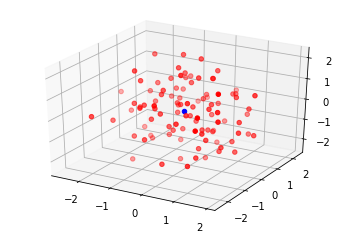

In [24]:
x0 = avg.reshape(8,1)
data = particles[:,:3]
print(data.shape)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(x0[0,:], x0[1,:], x0[2,:],c='blue')
ax.scatter(data[:,0], data[:,1], data[:,2], c='red')
plt.show()

### Predict based on previous State

In [25]:
particles.shape

(100, 8)

In [26]:
data = data_interface.read()
gps = data['gps_data']
imu = data['imu_data']
enc = data['encoders_data']

In [27]:
# data -> (lon,lat,alt,left,right,yaw,pitch,roll)
# meas_vector -> (x,y,z,v,w,yaw,pitch,roll)
lat,lon,alt = gps[1:4]
lat -= lat0
lon -= lon0
alt -= z0

pitch, roll, yaw = imu[5:8]
left,right = enc[1:3]

left -= left0
right -= right0

y_t = np.array([[lon,lat,alt,left,right,yaw,pitch,roll]]).T
print(y_t)

[[ 3.00000011e-07]
 [-3.99999998e-07]
 [ 6.20000000e-02]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-1.68914012e+02]
 [-1.99241344e-01]
 [ 6.31612644e-01]]


In [28]:
particles1 = np.zeros(particles.shape,dtype=np.float32)
weights1 = np.zeros((n_particles,), dtype=np.float32)

w_sum = 0
for i in range(n_particles,):
    f_x1 = stateUpdate(particles[i,:].reshape(8,1))
    mu = sig0 @ (Q_inv@f_x1 + C.T @ R_inv @ y_t)
    particles1[i,:] = np.random.multivariate_normal(mu.flatten(),sig0)
    
    weights1[i] = ((y_t - C@f_x1).T @ np.linalg.inv(sig0) @ (y_t - C@f_x1))[0,0]
    w_sum += weights1[i]
weights1 /= w_sum

In [29]:
particles[i,:].reshape(8,1)

array([[-0.91399268],
       [ 0.54429337],
       [ 1.09832148],
       [-0.26929409],
       [ 0.66356153],
       [-2.93134005],
       [-0.04652908],
       [-0.00541447]])

In [30]:
stateUpdate(particles[i,:].reshape(8,1))

array([[-0.65091396],
       [ 0.60043609],
       [ 1.11084696],
       [-0.26929409],
       [ 0.66356153],
       [-2.26777852],
       [-0.04652908],
       [-0.00541447]])

In [31]:
avg1 = np.sum( particles1 * weights1.reshape(n_particles,1), axis=0)
print(avg1)

[ 0.20337297 -0.2947672  -0.18736728  0.09631947 -0.07887129 -2.946792
 -0.00475602  0.01361013]


In [32]:
ESS1 = 1 / np.sum( weights1**2 )
print(ESS1)

40.47119740475787


(100, 3)


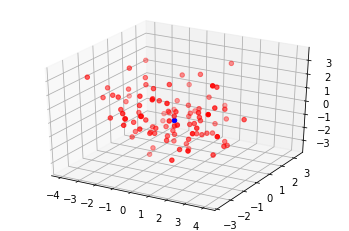

In [33]:
x0 = avg1.reshape(8,1)
data = particles1[:,:3]
print(data.shape)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(x0[0,:], x0[1,:], x0[2,:],c='blue')
ax.scatter(data[:,0], data[:,1], data[:,2], c='red')
plt.show()

### Resample

In [34]:
def resample(weights, particles, n_particles):
    #weights should be normalized
    choices = np.random.choice( np.arange(n_particles), n_particles, p=weights)
    particles_new = particles[choices,:]
    weights_new = 1/n_particles + np.zeros(weights.shape,dtype=np.float32)
    return weights_new, particles_new

In [35]:
choices = np.random.choice( np.arange(n_particles), n_particles, p=weights1 )
particles2 = particles1[choices, :]
weights2 = 1/n_particles + np.zeros(weights1.shape,dtype=np.float32)

In [36]:
ESS2 = 1 / np.sum( weights2**2 )
print(ESS2)

100.00002086163002


In [37]:
avg2 = np.sum( particles2 * weights2.reshape(n_particles,1), axis=0)
print(avg2)

[ 0.38245133 -0.30783254 -0.3303676   0.10883072 -0.08325347 -2.950598
 -0.00810439  0.01152299]


## Full Gaussian Particle Filter Implementation

In [124]:
class SensorReader:
    def __init__(self, radiusOfEarth, encoder_resolution, encoder_diameterL, encoder_diameterR):
        self.data_interface = DataInterface(
            "/home/an/workspace/Classes/Spring 2022/CS-179/Project/urban16/sensor_data/gps.csv",
            "/home/an/workspace/Classes/Spring 2022/CS-179/Project/urban16/sensor_data/xsens_imu.csv",
            "/home/an/workspace/Classes/Spring 2022/CS-179/Project/urban16/sensor_data/encoder.csv"
        )
        # data -> (lon,lat,alt,left,right,yaw,pitch,roll)
        self.R = radiusOfEarth
        self.res = encoder_resolution
        self.angle_to_rad = np.pi/180
        self.enc_radL = encoder_diameterL / 2
        self.enc_radR = encoder_diameterR / 2
        
        self.init_data = self.parse(self.data_interface.read())
        self.meas = self.init_data.copy()
        self.meas[0:5] = 0 #re-init
        
    def parse(self, data):
        gps = data['gps_data']
        imu = data['imu_data']
        enc = data['encoders_data']
        lat,lon,alt = gps[1:4]
        pitch, roll, yaw = imu[5:8]
        left,right = enc[1:3]
        
        lat = lat*np.pi/180*self.R
        lon = lon*np.pi/180*self.R
        left = left * 2*np.pi/self.res * self.enc_radL
        right = right * 2*np.pi/self.res * self.enc_radR
        
        #pitch = pitch * np.pi / 180
        #yaw = yaw * np.pi / 180
        #roll = roll * np.pi / 180
        
        return np.array([[lon,lat,alt,left,right,yaw,pitch,roll]]).T
    def read(self):
        self.meas = self.parse(self.data_interface.read())
        self.meas[0:5] -= self.init_data[0:5]
        return self.meas

In [111]:
R = 6_371_000 #earth's radius in meters
encDiamL = 0.623022
encDiamR = 0.622356
res = 4096
wheelbase = 1.5285

sensors = SensorReader(R, res, encDiamL, encDiamR)

In [112]:
data = np.array([[0,0,0,0,0,0,0,0]]).T
for i in range(1_000):
    data = np.hstack((data,sensors.read()))

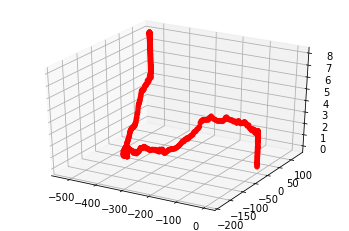

In [113]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(data[0,:], data[1,:], data[2,:], c='red')
plt.show()

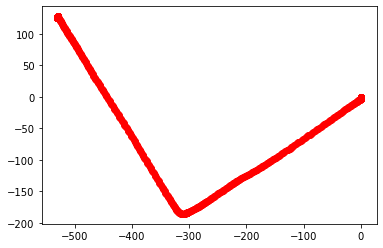

In [114]:
plt.scatter(data[0,:], data[1,:],c='red')
plt.show()

In [115]:
class GaussianParticleFilter:
    def __init__(self, systemCov, measCov, stateUpdate, measMatrix, initialMeas, n_particles=100, resample_thresh=20):
        '''
            systemCov = State Update Covariance Matrix
            measCov = Measurement Covariance Matrix (Sensor Covariances)
            stateUpdate = python function that takes in previous state and predicts next state
            measMatrix = matrix that converts state vector to measurement vector
            initialState = starting off state
        '''
        #init covariances
        self.Q = systemCov
        self.Q_inv = np.linalg.inv(self.Q)
        self.R = measCov
        self.R_inv = np.linalg.inv(self.R)
        
        #measurements
        self.C = measMatrix
        self.initialMeas = initialMeas
        self.n_particles = n_particles
        
        #init stateUpdates
        self.stateUpdate = stateUpdate
        
        #init paricles
        self.particles = np.zeros(shape=(n_particles,systemCov.shape[0]), dtype=np.float32)
        self.weights = np.zeros(shape=(n_particles,),dtype=np.float32)
        
        self.resample_thresh = resample_thresh
        for i in range(n_particles):
            self.particles[i] = self.initialMeas.flatten()
            self.weights[i] = 1/n_particles
        self.ESS = 1 / np.sum( self.weights**2 )
        
        
        self.sig0 = np.linalg.inv(self.Q_inv + self.C.T @ self.R_inv @ self.C)
    def convert_meas_to_state(self, meas):
        return np.linalg.inv(self.C)@meas
    def predict(self, meas):
        y_t = meas
        particles1 = np.zeros(self.particles.shape,dtype=np.float32)
        weights1 = np.zeros((self.n_particles,), dtype=np.float32)
        
        w_sum = 0
        for i in range(n_particles):
            f_x1 = self.stateUpdate(self.particles[i,:].reshape(8,1))
            mu = self.sig0 @ (self.Q_inv@f_x1 + self.C.T @ self.R_inv @ y_t)
            particles1[i,:] = np.random.multivariate_normal(mu.flatten(),self.sig0)

            weights1[i] = ((y_t - self.C@f_x1).T @ np.linalg.inv(self.sig0) @ (y_t - self.C@f_x1))[0,0]
            w_sum += weights1[i]
        weights1 /= w_sum
        self.particles = particles1
        self.weights = weights1
        
        self.ESS = 1 / np.sum( self.weights**2 )
        
        if self.ESS < self.resample_thresh:
            self.resample()

    def estimate(self):
        return np.sum( self.particles * self.weights.reshape(self.n_particles,1), axis=0)
    def resample(self):
        choices = np.random.choice( np.arange(self.n_particles), self.n_particles, p=self.weights)
        particles_new = self.particles[choices,:]
        weights_new = 1/self.n_particles + np.zeros(self.weights.shape,dtype=np.float32)
        
        self.particles = particles_new
        self.weights = weights_new
        
        self.ESS = 1 / np.sum( self.weights**2 )

In [116]:
def stateUpdate(state):
    x,y,z,v,w,yaw,pitch,roll = state[:,0]
    x = x + v*np.cos(pitch)*np.cos(yaw)
    #x = x + v*np.cos(yaw)
    y = y + v*np.cos(pitch)*np.sin(yaw)
    #y = y + v*np.sin(yaw)
    z = z + v*np.sin(pitch)
    
    yaw = yaw + w
    pitch = pitch
    roll = roll
    state_ = np.array([[x,y,z,v,w,yaw,pitch,roll]]).T
    return state_

In [138]:
C = np.zeros(shape=(8,8), dtype=np.float32)
#longitude
C[0,0] = 1
#latitude
C[1,1] = 1
#altitude
C[2,2] = 1

#left encoder
C[3,3] = 1
C[3,4] = -baseline/2

#right encoder
C[4,3] = 1
C[4,4] = baseline/2

#yaw, pitch, roll
C[5,5] = np.pi/180
C[6,6] = np.pi/180
C[7,7] = np.pi/180

In [139]:
R = 6_371_000 #earth's radius in meters
encDiamL = 0.623022
encDiamR = 0.622356
res = 4096
wheelbase = 1.5285

sensors = SensorReader(R, res, encDiamL, encDiamR)

In [140]:
systemCov = np.eye(8)*3
measCov = np.eye(8)*1
#measCov[0:3,0:3] = gps_cov

In [141]:
pf = GaussianParticleFilter(systemCov,measCov, stateUpdate, C, sensors.read() )

In [142]:
data = pf.estimate().reshape(8,1)
for i in range(10_000):
    reading = sensors.read()
    pf.predict(reading)
    data = np.hstack((data,pf.estimate().reshape(8,1)))

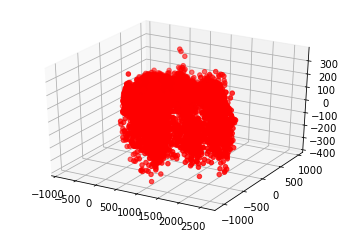

In [143]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(data[0,:], data[1,:], data[2,:], c='red')
plt.show()

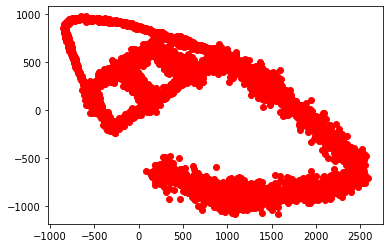

In [144]:
plt.scatter(data[0,:], data[1,:],c='red')
plt.show()

## Compare with Ground Truth